In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
## Convert sqlite file to csv - only run once
import sqlite3
db_file = '/Users/catiefinkenbiner/Documents/JobApps/DataIncubator/FPA_FOD_20170508.sqlite'

conn = sqlite3.connect(db_file, isolation_level=None,
                        detect_types=sqlite3.PARSE_COLNAMES)
df = pd.read_sql_query("select * from fires", conn)
df.to_csv('WildFires.csv', index=False)

In [3]:
## Read csv
df = pd.read_csv('WildFires.csv', index_col=None)
df.head()

/Users/catiefinkenbiner/.conda/envs/conda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


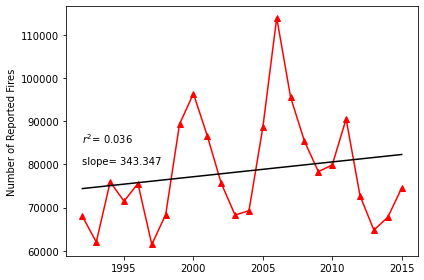

In [4]:
## Calculate Number of Fires per Year
years = np.arange(1992, 2016)
num_fires = []
for yr in years:
    df_yr = df[df['FIRE_YEAR'] == yr]
    num_fires.append(df_yr['OBJECTID'].nunique())
num_fires = np.array(num_fires)

slope, intercept, r_value, p_value, std_err = stats.linregress(years, num_fires)

plt.figure()
plt.plot(years, num_fires, 'r^-')
plt.plot(years, years*slope+intercept, 'k-')

plt.text(1992, 85000, r'$r^2$= %.3f' % r_value**2)
plt.text(1992, 80000, r'slope= %.3f' % slope)
plt.ylabel('Number of Reported Fires')
plt.tight_layout()
plt.savefig('Fig1_numfires.png',dpi=300)
plt.show() ; plt.close()

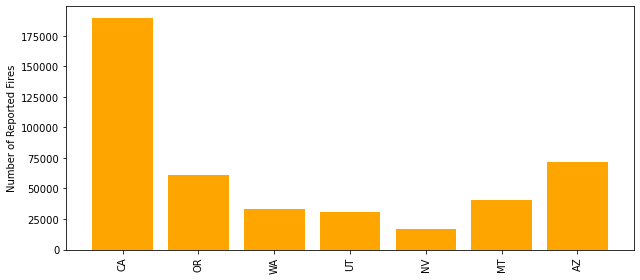

In [5]:
## Number of fires per state
states = ['CA','OR','WA','UT','NV','MT','AZ'] # df['STATE'].unique()
num_fires = []
for s in states:
    df_s = df[df['STATE'] == s]
    num_fires.append(df_s['OBJECTID'].nunique())
num_fires = np.array(num_fires)

plt.figure(figsize=(9,4))
plt.bar(states, num_fires, color='orange')

plt.xticks(rotation = 90)
plt.ylabel('Number of Reported Fires')
plt.tight_layout()
plt.savefig('Fig2_numfires_per_state.png',dpi=300)
plt.show() ; plt.close()

In [6]:
## Correlation between 'Latitude' and 'Fire Year'
slope, intercept, r_value, p_value, std_err = stats.linregress(df['LATITUDE'], df['FIRE_YEAR'])
print('r2=', r_value**2, 'p-value=', p_value)

r2= 1.6542350709854977e-07 p-value= 0.5770226617899084


In [8]:
## NLDAS Soils Dataset
import xarray as xr

soil_tex_netcdf4 = xr.open_dataset('/Users/catiefinkenbiner/Documents/JobApps/DataIncubator/NLDAS_masks-veg-soil.nc4')

# Start with OR
df_OR = df[df['STATE'] == 'OR']

soiltex = [] ; fire_yr = []
for l in np.arange(10000):
    dstex = soil_tex_netcdf4.sel(lon=df_OR['LONGITUDE'].iloc[l], lat=df_OR['LATITUDE'].iloc[l], method='nearest')
    soiltex.append(dstex['NLDAS_soil'].values)
    fire_yr.append(df_OR['FIRE_YEAR'].iloc[l])
soiltex = (np.array(soiltex)).ravel()

## Correlation between 'Latitude' and 'Soil Type'
slope, intercept, r_value, p_value, std_err = stats.linregress(soiltex, df_OR['FIRE_YEAR'].iloc[:10000])
print('r2=', r_value**2, 'p-value=', p_value)

r2= 5.150565686551689e-05 p-value= 0.4730076935998212


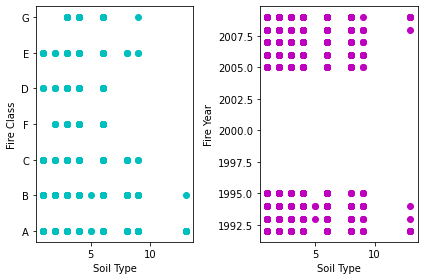

In [9]:
df_OR_soil = pd.DataFrame({'lat':df_OR['LATITUDE'].iloc[:10000], 'lon':df_OR['LONGITUDE'].iloc[:10000], 
                           'fire_year':df_OR['FIRE_YEAR'].iloc[:10000], 'fire_class':df_OR['FIRE_SIZE_CLASS'].iloc[:10000],
                           'soil':soiltex})
df_OR_soil.head()

plt.figure()
plt.subplot(1,2,1)
plt.plot(df_OR_soil['soil'], df_OR_soil['fire_class'], 'co')
plt.xlabel('Soil Type')
plt.ylabel('Fire Class')

plt.subplot(1,2,2)
plt.plot(df_OR_soil['soil'], df_OR_soil['fire_year'], 'mo')
plt.xlabel('Soil Type')
plt.ylabel('Fire Year')

plt.tight_layout()
plt.savefig('Fig3_OR_soils.png',dpi=300)
plt.show() ; plt.close()